# lib

In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
from keras.models import model_from_json

#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

import scipy.ndimage as ndimage
import numpy as np
from PIL import Image
import collections
from matplotlib import pyplot as plt
%matplotlib inline  

name_experiment = 'sadhguru_ravi_unet'

def pred_to_imgs(pred, patch_height, patch_width, mode="original"):
    # TODO: pred.shape = 702, 2304, 4
    assert (len(pred.shape)==3)  
    assert (pred.shape[2]==4 )  
    pred_images = np.empty((pred.shape[0],pred.shape[1]))  
    if mode=="original":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                pred_images[i,pix]=pred[i,pix,1] 
    elif mode=="threshold":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                if pred[i,pix,1]>=0.5:
                    pred_images[i,pix]=1
                else:
                    pred_images[i,pix]=0
    else:
        print("mode " +str(mode) +" not recognized, it can be 'original' or 'threshold'")
        exit()
    pred_images = np.reshape(pred_images,(pred_images.shape[0],1, patch_height, patch_width))
    return pred_images


def pred_to_imgs(pred, patch_height, patch_width, mode="original"):
    assert (len(pred.shape)==3)  
    assert (pred.shape[2]==4 ) 
    pred_images = np.empty((pred.shape[0],pred.shape[1]))  
    if mode=="original":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                pred_images[i,pix]=pred[i,pix,1]
    elif mode=="threshold":
        for i in range(pred.shape[0]):
            for pix in range(pred.shape[1]):
                pred_images[i,pix]=np.where(pred[i,pix,:]==np.max(pred[i,pix,:]))[0][0]
    else:
        print("mode " +str(mode) +" not recognized, it can be 'original' or 'threshold'")
        exit()
    pred_images = np.reshape(pred_images,(pred_images.shape[0],1, patch_height, patch_width))
    return pred_images


#Recompone the full images with the patches
def recompone(data,N_h,N_w):
    assert (data.shape[1]==1 or data.shape[1]==3) 
    assert(len(data.shape)==4)
    N_pacth_per_img = N_w*N_h
    print('data.shape: ',data.shape)
    print('N_pacth_per_img: ', N_pacth_per_img)
    assert(data.shape[0]%N_pacth_per_img == 0)
    N_full_imgs = data.shape[0]/N_pacth_per_img
    patch_h = data.shape[2]
    patch_w = data.shape[3]
    N_pacth_per_img = N_w*N_h
    #define and start full recompone
    full_recomp = np.empty((int(N_full_imgs),data.shape[1],int(N_h*patch_h),int(N_w*patch_w)))
    k = 0  #iter full img
    s = 0  #iter single patch
    while (s<data.shape[0]):
        #recompone one:
        single_recon = np.empty((data.shape[1],N_h*patch_h,N_w*patch_w))
        for h in range(N_h):
            for w in range(N_w):
                single_recon[:,h*patch_h:(h*patch_h)+patch_h,w*patch_w:(w*patch_w)+patch_w]=data[s]
                s+=1
        full_recomp[k]=single_recon
        k+=1
    assert (k==N_full_imgs)
    return full_recomp

#Define the neural network
def get_unet(n_ch,patch_height,patch_width):
    inputs = Input(shape=(n_ch,patch_height,patch_width))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1],axis=1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2], axis=1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = Conv2D(n_classes, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = core.Reshape((n_classes,patch_height*patch_width))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(input=inputs, output=conv7)

    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.3, nesterov=False)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

    return model

#return only the pixels contained in the FOV, for both images and masks
def pred_only_FOV(data_imgs,data_masks):
    assert (len(data_imgs.shape)==4 and len(data_masks.shape)==4)  #4D arrays
    assert (data_imgs.shape[0]==data_masks.shape[0])
    assert (data_imgs.shape[2]==data_masks.shape[2])
    assert (data_imgs.shape[3]==data_masks.shape[3])
    assert (data_imgs.shape[1]==1 and data_masks.shape[1]==1)  #check the channel is 1
    height = data_imgs.shape[2]
    width = data_imgs.shape[3]
    new_pred_imgs = []
    new_pred_masks = []
    for i in range(data_imgs.shape[0]):  #loop over the full images
        for x in range(width):
            for y in range(height):
                new_pred_imgs.append(data_imgs[i,:,y,x])
                new_pred_masks.append(data_masks[i,:,y,x])
    new_pred_imgs = np.asarray(new_pred_imgs)
    new_pred_masks = np.asarray(new_pred_masks)
    return new_pred_imgs, new_pred_masks


Using TensorFlow backend.


# Network Training 

In [2]:
n_classes = 4
N_epochs = 10
batch_size = 8

filename = './'+name_experiment+'/'+"sample_input_imgs"
if not os.path.exists(filename):
    os.makedirs(filename)
    
#=========== Construct and save the model arcitecture =====
n_ch = 3
patch_height = 48
patch_width = 48
model = get_unet(n_ch, patch_height, patch_width)  #the U-net model
print("Check: final output of the network:")
print(model.output_shape)
plot_model(model, to_file='./'+name_experiment+'/'+name_experiment + '_model.png',show_shapes=True)   #check how the model looks like
json_string = model.to_json()
open('./'+name_experiment+'/'+name_experiment +'_architecture.json', 'w').write(json_string)

checkpointer = ModelCheckpoint(filepath='./'+name_experiment+'/'+name_experiment +'_best_weights.h5', verbose=1, monitor='val_loss', mode='auto', save_best_only=True) #save at each epoch if the validation decreased

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:136: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


Check: final output of the network:
(None, 2304, 4)


In [3]:
patches_imgs_train=np.load('./raviData/patches_imgs_train.npy')
patches_masks_train_flatten=np.load('./raviData/patches_masks_train_flatten.npy')

patches_imgs_test=np.load('./raviData/patches_imgs_test.npy')
patches_masks_test_flatten=np.load('./raviData/patches_masks_test_flatten.npy')
patches_masks_test=np.load('./raviData/patches_masks_test.npy')

In [4]:
#============  Training ==================================
history = model.fit(patches_imgs_train, 
                    patches_masks_train_flatten, 
                    epochs=N_epochs, 
                    batch_size=batch_size, 
                    verbose=2, shuffle=True,  
                    validation_data=(patches_imgs_test, patches_masks_test_flatten), 
                    callbacks=[checkpointer])
# validation_split=0.1,
# validation_data=(patches_imgs_test, patches_masks_test_flatten), 

Train on 8877 samples, validate on 702 samples
Epoch 1/10
 - 13s - loss: 1.0103 - acc: 0.5214 - val_loss: 0.5905 - val_acc: 0.7396

Epoch 00001: val_loss improved from inf to 0.59052, saving model to ./sadhguru_ravi_unet/sadhguru_ravi_unet_best_weights.h5
Epoch 2/10
 - 10s - loss: 0.8032 - acc: 0.6161 - val_loss: 0.5602 - val_acc: 0.7825

Epoch 00002: val_loss improved from 0.59052 to 0.56021, saving model to ./sadhguru_ravi_unet/sadhguru_ravi_unet_best_weights.h5
Epoch 3/10
 - 11s - loss: 0.8326 - acc: 0.6149 - val_loss: 0.8681 - val_acc: 0.7518

Epoch 00003: val_loss did not improve from 0.56021
Epoch 4/10
 - 12s - loss: 0.6929 - acc: 0.7222 - val_loss: 0.3517 - val_acc: 0.8666

Epoch 00004: val_loss improved from 0.56021 to 0.35167, saving model to ./sadhguru_ravi_unet/sadhguru_ravi_unet_best_weights.h5
Epoch 5/10
 - 12s - loss: 0.6189 - acc: 0.7710 - val_loss: 0.3010 - val_acc: 0.8867

Epoch 00005: val_loss improved from 0.35167 to 0.30105, saving model to ./sadhguru_ravi_unet/sadh

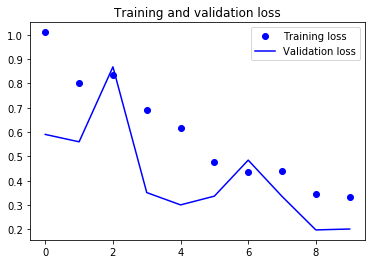

In [5]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_ = range(N_epochs)
plt.figure()
plt.plot(epochs_, loss, 'bo', label='Training loss')
plt.plot(epochs_, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

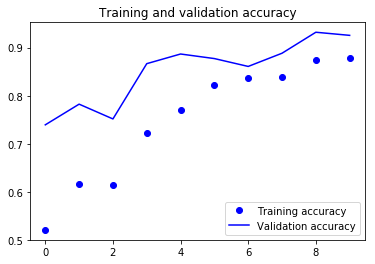

In [6]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs_ = range(N_epochs)
plt.figure()
plt.plot(epochs_, acc, 'bo', label='Training accuracy')
plt.plot(epochs_, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

# Network Testing

In [7]:
#================ Run the prediction of the patches ==================================
#Load the saved model
path_experiment = './'
model = model_from_json(open('./'+name_experiment+'/'+name_experiment +'_architecture.json').read())
model.load_weights('./'+name_experiment+'/'+name_experiment +'_best_weights.h5')
#Calculate the predictions
predictions = model.predict(patches_imgs_test, batch_size=32, verbose=2)
print("predicted images size :")
print(predictions.shape)

predicted images size :
(702, 2304, 4)


In [8]:
#===== Convert the prediction arrays in corresponding images
patch_height, patch_width = 48,48
pred_patches = pred_to_imgs(predictions, patch_height, patch_width, "threshold") # actually to patch, original threshold

patches_imgs_test.shape, pred_patches.shape

((702, 3, 48, 48), (702, 1, 48, 48))

In [9]:
#========== Elaborate and visualize the predicted images ====================
pred_imgs = recompone(pred_patches,18,39)       # predictions
orig_imgs = recompone(patches_imgs_test,18,39)  # originals
gtruth_masks = recompone(patches_masks_test,18,39)  #masks 

pred_imgs=pred_imgs.astype('uint8')
orig_imgs=orig_imgs.astype('uint8')
gtruth_masks=gtruth_masks.astype('uint8')

data.shape:  (702, 1, 48, 48)
N_pacth_per_img:  702
data.shape:  (702, 3, 48, 48)
N_pacth_per_img:  702
data.shape:  (702, 1, 48, 48)
N_pacth_per_img:  702


In [10]:
print("Orig imgs shape: " +str(orig_imgs.shape))
print("pred imgs shape: " +str(pred_imgs.shape))
print("Gtruth imgs shape: " +str(gtruth_masks.shape))

Orig imgs shape: (1, 3, 864, 1872)
pred imgs shape: (1, 1, 864, 1872)
Gtruth imgs shape: (1, 1, 864, 1872)


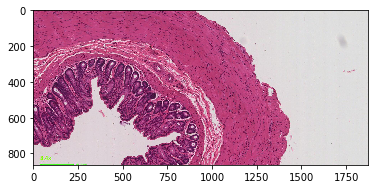

In [11]:
# Original Image
plt.imshow(np.moveaxis(orig_imgs[0],0,-1))

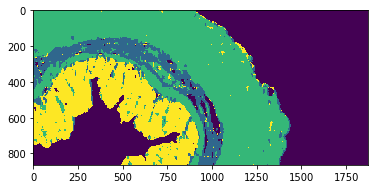

In [12]:
# Prediction
plt.imshow(pred_imgs[0][0])

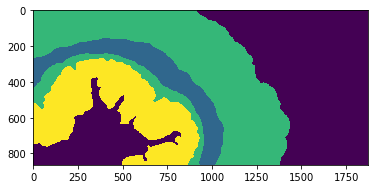

In [13]:
# Ground truth 
plt.imshow(gtruth_masks[0][0])

# Performance Evaluation

In [14]:
#====== Evaluate the results
print("\n\n========  Evaluate the results =======================")
#predictions only inside the FOV
y_scores, y_true = pred_only_FOV(pred_imgs,gtruth_masks)  
print("Calculating results only inside the FOV:")
print("y scores pixels: " +str(y_scores.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(pred_imgs.shape[0]*pred_imgs.shape[2]*pred_imgs.shape[3]) +" (584*565==329960)")
print("y true pixels: " +str(y_true.shape[0]) +" (radius 270: 270*270*3.14==228906), including background around retina: " +str(gtruth_masks.shape[2]*gtruth_masks.shape[3]*gtruth_masks.shape[0])+" (584*565==329960)")

#Confusion matrix
threshold_confusion = 0.5
print("\nConfusion matrix:  Costum threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print(confusion)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print("Precision: " +str(precision))

#Jaccard similarity index
jaccard_index = jaccard_similarity_score(y_true, y_pred, normalize=True)
print("\nJaccard similarity score: " +str(jaccard_index))



========  Evaluate the results =======================
Calculating results only inside the FOV:
y scores pixels: 1617408 (radius 270: 270*270*3.14==228906), including background around retina: 1617408 (584*565==329960)
y true pixels: 1617408 (radius 270: 270*270*3.14==228906), including background around retina: 1617408 (584*565==329960)

Confusion matrix:  Costum threshold (for positive) of 0.5
[[661398   3827      0      0]
 [ 14417 129615      0      0]
 [  3353 527705      0      0]
 [  4515 272578      0      0]]
Global Accuracy: 0.48906212903608737
Specificity: 0.994247059265662
Sensitivity: 0.8999041879582315
Precision: 0.9713208734881071

Jaccard similarity score: 0.48906212903608737
